In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from mrlattice.plotting import generate_plot_lattice, plot_mesh
from mrlattice.lattice.generate import LatticeArray, SuperimposeLatticeArray
from mrlattice.lattice import configure
from mrlattice.lattice.validate import ModifierHistoryError

FIXED_WIDTH = configure.LatticeArrayScheme.FIXED_WIDTH_SCHEME
FIXED_NUMBER = configure.LatticeArrayScheme.FIXED_NUMBER_SCHEME

In [2]:
# this notebook requires mrlattice version:
VERSION = "0.2.1"

In [3]:
%run prepare_notebook.ipynb

The following names are now available:

<class '__main__.LatticeArrayPlotWidget'>
<class '__main__.SuperimposeLatticeArrayPlotWidget'>


In [4]:
%load_ext jupyter_spaces

In [5]:
# interactive plots in notebook
# %matplotlib notebook
# open external window with plot
# %matplotlib qt
# for saving widget state
%matplotlib inline

if "inline" in matplotlib.get_backend():
    plt.rcParams["figure.figsize"] = (14, 14)
else:
    plt.rcParams["figure.figsize"] = (8, 8)
plt.rcParams["font.size"] = 14

# Modifier History

Until now we have introduced 4 different LatticeArray modifiers:
- spatial mirror
- temporal mirror
- spatial extend
- superimpose

We now want to reiterate on their implementation and introduce the concept of a modifier history.

## Temporal Extend

However, first we will complete the above set of modifiers with the `temporal_extend` modifier. As its name suggests, it will append two lattice arrays together in the temporal direction.

In [6]:
def temporal_extend(bottom, top, out=None) -> np.ndarray:
    """Append lattice array `top` on temporal top of `bottom`.

    Args:
        bottom: Lattice array on the temporal bottom.
        top: Lattice array on the temporal top.
        out: Lattice array to save output.

    All args must have the same spatial dimension and dtype.

    Returns:
        If `out` is given, change `out` in place and return `out`.
        Else return new lattice array.

    Raises:
        LatticeGenerationError:
            If `bottom` and `top` don't have same spatial dim.
        TypeError:
            If `out` doesn't have `dtype=object`.
    """
    # spatial dims of touching time slices
    bottom_dim = sum(reg[1] * reg[-1] for reg in bottom[-1])
    top_dim = sum(reg[1] * reg[-1] for reg in top[0])
    if bottom_dim != top_dim:
        raise LatticeGenerationError(
            f"Spatial dimension mismatch:\n{top=}\nand\n{bottom=}",
            "spatial dimension",
        )

    return np.concatenate((bottom, top), axis=0, out=out)

The heavy lifting is done by the numpy routine `concatenate`. Still, we have to check if the spatial dimensions of the two lattice arrays are compatible. This "dimension" is hidden for numpy. Also the order of the `bottom` and `top` arguments needs care. We have to keep in mind that the last time slice (i.e. `array[-1]`) is the top-most slice in the lattice with the largest time coordinate.

LatticeArrayPlotWidget(children=(VBox(children=(HBox(children=(VBox(children=(Label(value='Number of Borders b…

Output()

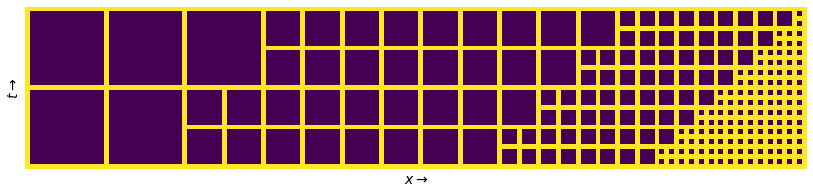

In [7]:
%%space temp_mirr
lattice = LatticeArray(
    scheme=FIXED_NUMBER,
    coarse_steps=3,
    borders_width=8,
    buffer=2,
    finest_width=1,
    repeat=2,
)
w = LatticeArrayPlotWidget(lattice=lattice)
display(w)
w._plot_button_on_click()

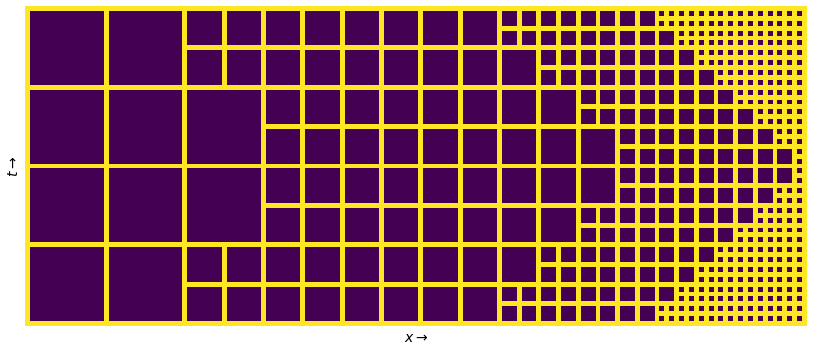

In [8]:
%%space temp_mirr
_ = plot_mesh(
    generate_plot_lattice(
        temporal_extend(
            lattice.array,
            LatticeArray.temporal_mirror_array(lattice.array),
        )
    )
)

## Recording Modifier Steps

A flaw of the current way modifiers are used, like demonstrated above, is that they intentionally work directly with the lattice arrays and not the LatticeArray instances. This means that using a modifier decouples the lattice array from the LatticeArray instance it originated from. A dirty solution would be to save the modified array back to the `LatticeArray._array` property. But this leads to problems, other than bad code design.

Assigning or changing `LatticeArray._array` manually circumvents the mechanisms for keeping the properties of LatticeArrays up to date. One can argue, that after such fundamental modifications, like `spatial_extend`, the old properties no longer make sense because they no longer describe the lattice. While this is true for now, with version 0.2.1 we add new properties ("volatile" properties) that actually need to stay up to date with those changes. Furthermore we would like to keep track of the changes we make to LatticeArrays and be able to query them later, for example for duplication.

The idea is to save a list of modifier function pointers and their arguments that contains all the necessary information to replay the modifications whenever necessary. We store this list as a protected attribute `_modifier_history` of `LatticeArray`.

Some of the modifier functions require partners. Ideally, these partners also need to be saved to the history. But instead of saving the lattice arrays themselves, it is more efficient to only save the information necessary to recreate the partner. This information contains the LatticeArray (sub-)type, the values of its LatticeArrayProperties and the `_modifier_history` of the partner. ( the introduction of the modifier history already comes in handy here.)

The complete signature of `_modifier_history` is:
```python
_modifier_history: list[tuple[(*args, **kwargs) -> Any, tuple, dict]]
```
The list consists of tuples with the values being the modifier function pointer and a tuple and dictionary for the positional and keyword arguments to pass to the modifier function.

We now proceed with adding methods to `LatticeArray` that are wrappers for the staticmethod modifier functions. These wrappers take care of changing the `LatticeArray._array`, amending to the history and triggering the update of the volatile properties. They also need to be able to recreate the partners from the modifier history when rebuilding the lattice array.

Their basic structure is as follows:

In [9]:
def modifier_array(array1, array2, out=None) -> np.ndarray:
    """Example modifier function.
    
    Works directly on lattice arrays. Is intended as staticmethod for LatticeArray types.
    """
    # do something with array1 and array2
    # write to out if given
    # return out or new lattice array
    
def modifier(self, other: LatticeArray):
    """Public method for this modifier."""
    # wrapper for _modifier
    self._modifier(*other.fingerprint, tmpLA=other)
    
def _modifier(self, prop_dict, mod_hist, lattice_type, tmpLA=None):
    if not tmpLA:
        # create tmp copy
        tmpLA = lattice_type(**prop_dict)
        tmpLA._modifier_history = mod_hist
        tmpLA.generate_array()

    # change self._array inplace
    self.modifier_array(self.array, tmpLA.array, out=self._array)
    self.update_volatile_properties()
    self._modifier_history.append(
        (
            type(self)._modifer,
            (prop_dict, mod_hist, lattice_type),
            dict(),
        )
    )

We split out the wrapper into one public and one protected method. The idea is, that the protected method handles the recreation of the partner lattice array as well as the housekeeping for volatile properties and the modifier history. Only the protected method enters the history. As such, when rebuilding the array, only calls to the protected methods will happen. The public method extracts the information from the partner, that will be saved to the history and accepts the partner as a `LatticeArray` type.
If the modifier had not partner, then combining the public and protected modifier methods is possible, as it is not necessary to reconstruct a partner.

We also make use of the new
```python
LatticeArray.fingerprint: tuple[
    dict[str, int | str],
    list[tuple[(*args, **kwargs) -> Any, tuple, dict]],
    type
]
```
property. This tuple stores a dictionary with all the values for the LatticeArrayProperties and the LatticeArrayScheme name as its first element. The second element is a copy of the modifier history. The last element is the exact subtype of the instance the property is called on. This we consider as all the data necessary to uniquely describe any given lattice.

Rebuilding the array (or "replaying history") then becomes as simple as looping through the history and calling all modifier functions. To prevent recursion, clearing the history when starting the replay is necessary. With the proper exception handling, we guarantee that if a modifier function fails, because the LatticeArray is no longer compatible with the partner, we just abort at the current step. When catching the raised `ModifierHistoryError` it is possible to still use the LatticeArray instance that now has a truncated history. The full history is accessible through the exception instance if needed.

In [10]:
def replay_modifier_history(self):
    """Replay modifications from history."""
    replay = self._modifier_history
    self._modifier_history = list()
    try:
        for step, (func, args, kwargs) in enumerate(replay):
            func(self, *args, **kwargs)
    except (TypeError, LatticeGenerationError) as e:
        raise ModifierHistoryError(repr(self), step, replay) from e

## Examples

LatticeArrayPlotWidget(children=(VBox(children=(HBox(children=(VBox(children=(Label(value='Number of Borders b…

Output()

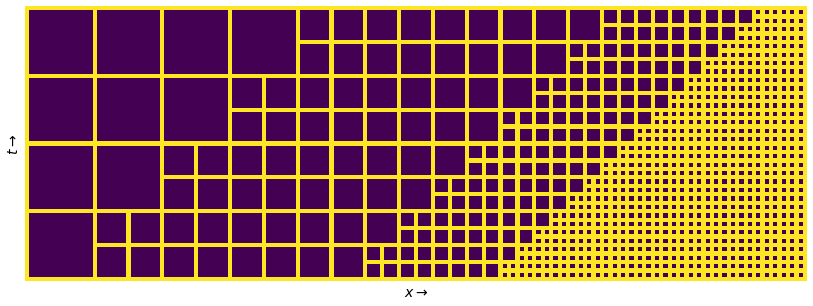

In [11]:
%%space mosaic
lattice = LatticeArray(
    scheme=FIXED_NUMBER,
    coarse_steps=3,
    borders_width=8,
    buffer=1,
    finest_width=6,
    repeat=4,
)
w = LatticeArrayPlotWidget(lattice=lattice)
display(w)
w._plot_button_on_click()

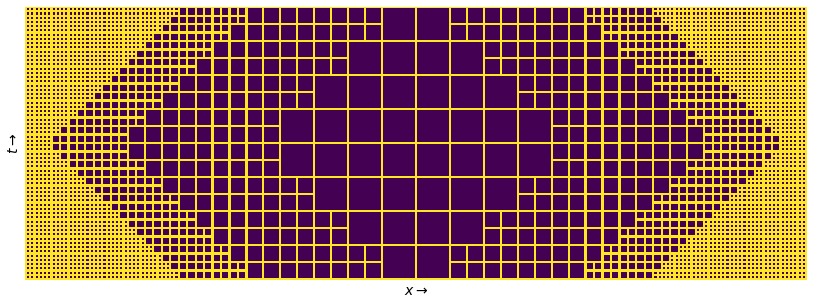

In [12]:
%%space mosaic
# a copy of lattice
partner1 = LatticeArray(
    scheme=FIXED_NUMBER,
    coarse_steps=3,
    borders_width=8,
    buffer=1,
    finest_width=6,
    repeat=4,
)
partner1.generate_array()
# spatial append to mirrored lattice
lattice.spatial_mirror()
lattice.spatial_extend(partner1)

# create new partner based on current lattice state
prop_dict, mod_hist, lat_type = lattice.fingerprint
partner2 = lat_type(**prop_dict)
partner2._modifier_history = mod_hist
partner2.generate_array()
partner2.temporal_mirror()
# and temporal append it
lattice.temporal_extend(partner2)

_ = plot_mesh(generate_plot_lattice(lattice.array))

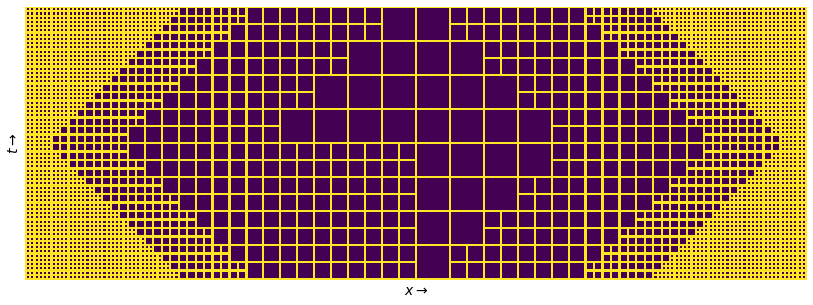

In [13]:
%%space mosaic

# deliberately "destorying" partner arrays
# shows that `lattice` is independent
partner1._array = None
partner2._array = None

# change the original lattice array and observe how the rest is still the same
lattice.coarse_steps.value = 2
lattice.borders_width.value = 8
lattice.buffer.value = 10
lattice.finest_width.value = 6
lattice.repeat.value = 8
lattice.generate_array()

_ = plot_mesh(generate_plot_lattice(lattice.array))

In [14]:
%%space mosaic

# this change is not compatible with all of the modifier history
lattice.coarse_steps.value = 2
lattice.borders_width.value = 8
lattice.buffer.value = 1
lattice.finest_width.value = 6
lattice.repeat.value = 8
print("original history length: ", len(lattice._modifier_history))
try:
    lattice.generate_array()
except ModifierHistoryError:
    print("truncated history length: ", len(lattice._modifier_history))

# but the lattice is still in tact
_ = plot_mesh(generate_plot_lattice(lattice.array))

original history length:  3
truncated history length:  2
